In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

from clean import clean_games

Let's clean & load our data. For time's sake, we're only going to use years 1990-2020.

In [2]:
game_df = clean_games("data/games_scraped.pickle", start_year=1990)

In [3]:
game_df.shape

(6559, 148)

In [4]:
pd.set_option("display.max_columns", 250)
pd.set_option("display.max_rows", 73)

In [5]:
# print all columns
for col_name in game_df.columns:
    print(col_name)

team
year
team_year
date
opp
week_num
log_year
game_day_of_week
game_outcome
team_record
pts_off
margin
pts_def
first_down_off
yards_off
pass_yds_off
rush_yds_off
to_off
first_down_def
yards_def
pass_yds_def
rush_yds_def
to_def
game_time
overtime
team_home_game
to2_off
to2_def
game_id
result_tie
result_win
wins
losses
ties
season_week
playoff_game
prev_season_week
prev_wins
prev_losses
prev_ties
prev_pts_off
prev_pts_def
prev_margin
prev_first_down_off
prev_yards_off
prev_pass_yds_off
prev_rush_yds_off
prev_to_off
prev_to2_off
prev_first_down_def
prev_yards_def
prev_pass_yds_def
prev_rush_yds_def
roll3_num_ties
roll3_num_wins
prev_to_def
prev_to2_def
prev_result_tie
prev_result_win
off_bye
roll3_result_win
roll3_result_tie
roll3_pts_off
roll3_pts_def
roll3_margin
roll3_first_down_off
roll3_yards_off
roll3_pass_yds_off
roll3_rush_yds_off
roll3_to_off
roll3_to2_off
roll3_yards_def
roll3_pass_yds_def
roll3_rush_yds_def
roll3_to_def
roll3_to2_def
ewma_result_win
ewma_result_tie
ewma_pts_of

In [6]:
# construct a list containing all of the columns we could use in model
indicators = ['prev_', 'roll3', 'ewma_']
key_variables = [col for col in game_df.columns if col[:5] in indicators]
key_variables.sort()

additional = ['year', 'date', 'team', 'team_home_game', 'opp', 'margin']

for col in additional[::-1]:
    key_variables.insert(0, col)

key_variables

['year',
 'date',
 'team',
 'team_home_game',
 'opp',
 'margin',
 'ewma_first_down_off',
 'ewma_first_down_off_opp',
 'ewma_margin',
 'ewma_margin_opp',
 'ewma_pass_yds_def',
 'ewma_pass_yds_def_opp',
 'ewma_pass_yds_off',
 'ewma_pass_yds_off_opp',
 'ewma_pts_def',
 'ewma_pts_def_opp',
 'ewma_pts_off',
 'ewma_pts_off_opp',
 'ewma_result_tie',
 'ewma_result_win',
 'ewma_result_win_opp',
 'ewma_result_win_opp',
 'ewma_rush_yds_def',
 'ewma_rush_yds_def_opp',
 'ewma_rush_yds_off',
 'ewma_rush_yds_off_opp',
 'ewma_to2_def',
 'ewma_to2_def_opp',
 'ewma_to2_off',
 'ewma_to2_off_opp',
 'ewma_to_def',
 'ewma_to_def_opp',
 'ewma_to_off',
 'ewma_to_off_opp',
 'ewma_yards_def',
 'ewma_yards_def_opp',
 'ewma_yards_off',
 'ewma_yards_off_opp',
 'prev_first_down_def',
 'prev_first_down_def_opp',
 'prev_first_down_off',
 'prev_first_down_off_opp',
 'prev_losses',
 'prev_losses_opp',
 'prev_margin',
 'prev_margin_opp',
 'prev_pass_yds_def',
 'prev_pass_yds_def_opp',
 'prev_pass_yds_off',
 'prev_pass_y

Our DF is still too large to use `df.info()`.

Let's split the columns into sections. Since we have so many columns, we need to do quite a bit of splitting.

Let's start with a small selection of columns.

In [7]:
small_df = game_df[['margin', 'team', 'opp', 'game_id', 'year', 'roll3_margin',
                    'ewma_margin', 'roll3_to_off', 'roll3_to2_off', 'ewma_to_def', 'ewma_to2_def']]

In [8]:
indicators = ['prev_', 'roll3', 'ewma_']

prev_vars = [col for col in game_df.columns if col[:5] == 'prev_']
roll3_vars = [col for col in game_df.columns if col[:5] == 'roll3']
ewma_vars = [col for col in game_df.columns if col[:5] == 'ewma_']

# remove dupe in ewma_vars
ewma_vars = list(dict.fromkeys(ewma_vars))

for grp in [prev_vars, roll3_vars, ewma_vars]:
    for col in additional[::-1]:
        grp.insert(0, col)

prev_df = game_df[prev_vars]
roll3_df = game_df[roll3_vars]
ewma_df = game_df[roll3_vars]

In [9]:
# sns.pairplot(small_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [10]:
game_df['def_summ_test1'] = \
    ((game_df['ewma_yards_def'].to_numpy() / (game_df['ewma_to_def'].to_numpy() + 1)
      .astype(float)))

game_df['def_summ_test2'] = \
    ((game_df['ewma_yards_def'].to_numpy() / (game_df['ewma_to2_def'].to_numpy() + 1)
     .astype(float)))

def_df = game_df[['year', 'team', 'opp', 'margin', 'ewma_result_win', 'ewma_yards_def',
                  'ewma_to_def', 'ewma_to2_def', 'def_summ_test1', 'def_summ_test2']]
def_df.head(5)


,year,team,opp,margin,ewma_result_win,ewma_yards_def,ewma_to_def,ewma_to2_def,def_summ_test1,def_summ_test2
0,1990,crd,was,-28.0,0.332,321.577,1.371,3.360,135.629270,73.756193
1,1990,crd,dal,17.0,0.233,355.755,0.961,2.357,181.415094,105.974084
2,1990,crd,nyg,-1.0,0.427,291.072,1.477,4.037,117.509891,57.786778
3,1990,crd,chi,-10.0,0.332,297.740,1.593,4.029,114.824528,59.204613
4,1990,crd,mia,-20.0,0.265,314.725,1.474,3.418,127.213015,71.236985


In [11]:
# sns.pairplot(def_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [12]:
# new ewma cols? i.e. ewma_total_yards_off - ewma_total_yards_off_opp

# create list of all ewma vars + row indicators & remove dupes
ewma_vars
ewma_vars

['year',
 'date',
 'team',
 'team_home_game',
 'opp',
 'margin',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']

In [13]:
opp_ewmas = [var for var in ewma_vars if var[-4:] == '_opp']
team_ewmas = [var for var in ewma_vars[6:] if var not in opp_ewmas]

opp_ewmas.sort()
team_ewmas.sort()

In [14]:
opp_ewmas, team_ewmas

(['ewma_first_down_off_opp',
  'ewma_margin_opp',
  'ewma_pass_yds_def_opp',
  'ewma_pass_yds_off_opp',
  'ewma_pts_def_opp',
  'ewma_pts_off_opp',
  'ewma_result_win_opp',
  'ewma_rush_yds_def_opp',
  'ewma_rush_yds_off_opp',
  'ewma_to2_def_opp',
  'ewma_to2_off_opp',
  'ewma_to_def_opp',
  'ewma_to_off_opp',
  'ewma_yards_def_opp',
  'ewma_yards_off_opp'],
 ['ewma_first_down_off',
  'ewma_margin',
  'ewma_pass_yds_def',
  'ewma_pass_yds_off',
  'ewma_pts_def',
  'ewma_pts_off',
  'ewma_result_tie',
  'ewma_result_win',
  'ewma_rush_yds_def',
  'ewma_rush_yds_off',
  'ewma_to2_def',
  'ewma_to2_off',
  'ewma_to_def',
  'ewma_to_off',
  'ewma_yards_def',
  'ewma_yards_off'])

In [15]:
plot_cols = game_df.loc[:, ['ewma_margin', 'ewma_margin_opp', 'ewma_pts_off',
                'ewma_pts_def', 'ewma_pts_off_opp', 'ewma_pts_def_opp',
                'ewma_to2_off', 'ewma_to2_def', 'ewma_to2_off_opp', 'ewma_to2_def_opp',
                   'margin']]



In [16]:
# sns.pairplot(plot_cols, plot_kws=dict(alpha=.1, edgecolor='none'))

In [17]:
plot_cols.describe()

,ewma_margin,ewma_margin_opp,ewma_pts_off,ewma_pts_def,ewma_pts_off_opp,ewma_pts_def_opp,ewma_to2_off,ewma_to2_def,ewma_to2_off_opp,ewma_to2_def_opp,margin
count,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000
mean,0.172642,0.513378,21.609958,21.437301,21.718997,21.205618,4.757419,4.875785,4.779680,4.876338,-0.527824
std,7.389596,7.478395,5.277361,4.734322,5.284417,4.796117,2.756536,2.879775,2.958181,2.790398,14.807161
min,-37.991000,-32.195000,2.048000,4.038000,4.038000,5.165000,0.000000,0.000000,0.000000,0.000000,-58.000000
25%,-4.909000,-4.516500,17.974500,18.222500,18.062500,17.833500,2.809000,2.850000,2.651000,2.867500,-10.000000
50%,0.347000,0.578000,21.387000,21.256000,21.532000,21.046000,4.274000,4.336000,4.247000,4.415000,-1.000000
75%,5.389500,5.611000,24.985000,24.588500,25.085000,24.431500,6.217500,6.270500,6.237500,6.343500,8.000000
max,29.718000,29.049000,46.423000,43.172000,44.873000,38.619000,30.369000,27.778000,43.304000,30.528000,59.000000


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

def split_and_validate(X, y):
    '''
        For a set of features and target X, y, perform a 80/20 train/val split, 
        fit and validate a linear regression model, and report results
    '''
    #Feature scaling for train, val, and test
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X.values)
    X_val_scaled = scaler.transform(X.values)
    X_test_scaled = scaler.transform(X.values)
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    
    return lr_model

In [93]:
game_df.columns

Index(['team', 'year', 'team_year', 'date', 'opp', 'week_num', 'log_year',
       'game_day_of_week', 'game_outcome', 'team_record',
       ...
       'ewma_rush_yds_off_opp', 'ewma_to_off_opp', 'ewma_to2_off_opp',
       'ewma_yards_def_opp', 'ewma_pass_yds_def_opp', 'ewma_rush_yds_def_opp',
       'ewma_to_def_opp', 'ewma_to2_def_opp', 'def_summ_test1',
       'def_summ_test2'],
      dtype='object', length=150)

In [94]:
mask = game_df['team_year'] == 'chi-2019'
game_df[mask][['ewma_pts_off', 'ewma_pts_def']]

,ewma_pts_off,ewma_pts_def
2345,17.834,13.205
2346,17.286,11.053
2347,18.225,14.328
2348,19.734,19.156
2349,18.982,18.721
2350,18.055,19.331
2351,18.394,18.229
2352,16.516,18.026
2353,16.907,17.393
2354,17.981,17.787


Let's try all of the roll3 columns and compare the results to ewma columns. 

In [95]:
ewma_cols = [col for col in game_df.columns if col[:4] == 'ewma']
roll3_cols = [col for col in game_df.columns if col[:4] == 'roll']

In [96]:
ewma_cols = list(set(ewma_cols))

In [97]:
X = game_df[ewma_cols]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.05446593353502871
Feature coefficient results: 

ewma_yards_off_opp : 144.29
ewma_to2_off : 0.02
ewma_pts_off : -67.82
ewma_pass_yds_off_opp : -137.14
ewma_pts_def_opp : 12.68
ewma_to2_off_opp : -0.03
ewma_pass_yds_def : 1154.01
ewma_pts_def : 60.84
ewma_to_off_opp : 0.04
ewma_to2_def : 0.01
ewma_rush_yds_def_opp : -231.29
ewma_to_def : -0.04
ewma_pass_yds_def_opp : -363.71
ewma_to2_def_opp : -0.01
ewma_result_win : 0.02
ewma_yards_def_opp : 424.76
ewma_first_down_off_opp : -0.03
ewma_result_tie : -0.00
ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_yards_off : -145.92
ewma_margin : 95.06
ewma_pass_yds_off : 137.90
ewma_rush_yds_off_opp : -76.00
ewma_to_off : -0.03
ewma_rush_yds_def : 769.64
ewma_first_down_off : 0.03
ewma_margin_opp : 19.72
ewma_to_def_opp : 0.02
ewma_pts_off_opp : -13.99
ewma_rush_yds_off : 79.84
ewma_yards_def : -1342.46


LinearRegression()

In [98]:
X = game_df[roll3_cols]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.04921704208252997
Feature coefficient results: 

roll3_num_ties : 1738156001978.52
roll3_num_wins : -1738156001985.15
roll3_result_win : 6.65
roll3_result_tie : -0.00
roll3_pts_off : 128.31
roll3_pts_def : -122.34
roll3_margin : -182.27
roll3_first_down_off : 0.01
roll3_yards_off : -2452.21
roll3_pass_yds_off : 2300.34
roll3_rush_yds_off : 1435.08
roll3_to_off : -0.01
roll3_to2_off : 0.01
roll3_yards_def : -560.85
roll3_pass_yds_def : 498.64
roll3_rush_yds_def : 327.68
roll3_to_def : -0.04
roll3_to2_def : 0.01
roll3_result_win_opp : -0.03
roll3_result_tie_opp : -0.06
roll3_result_tie_opp : 0.01
roll3_result_tie_opp : 0.03
roll3_result_tie_opp : 0.02
roll3_pts_off_opp : -4.83
roll3_pts_def_opp : 4.58
roll3_margin_opp : 6.81
roll3_first_down_off_opp : -0.01
roll3_yards_off_opp : 384.04
roll3_pass_yds_off_opp : -360.58
roll3_rush_yds_off_opp : -217.76
roll3_to_off_opp : 0.02
roll3_to2_off_opp : -0.02
roll3_yards_def_opp : -1297.48
roll3_pass_yds_def_opp : 1135

LinearRegression()

At first glance, it appears ewma is better. Let's break them into halves to confirm.

In [99]:
split = len(ewma_cols) // 2

X = game_df[ewma_cols[:split]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.06075346367930501
Feature coefficient results: 

ewma_yards_off_opp : -0.07
ewma_to2_off : 0.00
ewma_pts_off : 0.07
ewma_pass_yds_off_opp : -0.01
ewma_pts_def_opp : 0.05
ewma_to2_off_opp : -0.04
ewma_pass_yds_def : 0.00
ewma_pts_def : -0.07
ewma_to_off_opp : 0.06
ewma_to2_def : 0.01
ewma_rush_yds_def_opp : 0.02
ewma_to_def : -0.04
ewma_pass_yds_def_opp : 0.01
ewma_to2_def_opp : -0.01
ewma_result_win : 0.02


LinearRegression()

In [100]:
split = len(roll3_cols) // 2

X = game_df[roll3_cols[:split]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.014232460532737523
Feature coefficient results: 

roll3_num_ties : -3.68
roll3_num_wins : -3.68
roll3_result_win : 7.37
roll3_result_tie : -0.00
roll3_pts_off : 157.83
roll3_pts_def : -150.49
roll3_margin : -224.22
roll3_first_down_off : 0.00
roll3_yards_off : -2262.00
roll3_pass_yds_off : 2121.91
roll3_rush_yds_off : 1323.77
roll3_to_off : -0.02
roll3_to2_off : 0.02
roll3_yards_def : -766.40
roll3_pass_yds_def : 681.38
roll3_rush_yds_def : 447.78
roll3_to_def : -0.03


LinearRegression()

And now the other half...

In [101]:
split = len(ewma_cols) // 2

X = game_df[ewma_cols[split:]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.05576070879204431
Feature coefficient results: 

ewma_yards_def_opp : 0.01
ewma_first_down_off_opp : -0.03
ewma_result_tie : -0.01
ewma_result_win_opp : -0.02
ewma_result_win_opp : -0.02
ewma_yards_off : -122.20
ewma_margin : 0.08
ewma_pass_yds_off : 115.49
ewma_rush_yds_off_opp : 0.00
ewma_to_off : -0.01
ewma_rush_yds_def : -0.00
ewma_first_down_off : 0.03
ewma_margin_opp : -0.06
ewma_to_def_opp : 0.01
ewma_pts_off_opp : -0.01
ewma_rush_yds_off : 66.87
ewma_yards_def : -0.01


LinearRegression()

In [102]:
split = len(roll3_cols) // 2

X = game_df[roll3_cols[split:]]
y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.03061971897109972
Feature coefficient results: 

roll3_to2_def : 0.00
roll3_result_win_opp : -0.03
roll3_result_tie_opp : -0.00
roll3_result_tie_opp : -0.00
roll3_result_tie_opp : -0.00
roll3_result_tie_opp : -0.00
roll3_pts_off_opp : -27.74
roll3_pts_def_opp : 26.33
roll3_margin_opp : 39.43
roll3_first_down_off_opp : -0.01
roll3_yards_off_opp : 331.59
roll3_pass_yds_off_opp : -311.34
roll3_rush_yds_off_opp : -188.02
roll3_to_off_opp : 0.02
roll3_to2_off_opp : -0.02
roll3_yards_def_opp : -1276.07
roll3_pass_yds_def_opp : 1116.88
roll3_rush_yds_def_opp : 744.38
roll3_to_def_opp : 0.01
roll3_to2_def_opp : 0.00


LinearRegression()

Okay, that checks out. Moving forward, we'll use columns with the `ewma` prefix.

Let's also start factoring in home game, which we know often impacts who wins a game.

Here, we'll introduce `off_bye`, which tells us whether or not the team is coming off a bye week. Perhaps teams play better when they've had an extra week of rest time.

In [103]:
X = game_df[[
 'off_bye',
 'off_bye_opp',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.0832727560447134
Feature coefficient results: 

off_bye : 20593166.13
off_bye_opp : 1008099407515.20
team_home_game : 0.08
ewma_result_win : 0.02
ewma_result_tie : -0.00
ewma_pts_off : -56.20
ewma_pts_def : 50.41
ewma_margin : 78.79
ewma_first_down_off : 0.03
ewma_yards_off : -220.81
ewma_pass_yds_off : 208.69
ewma_rush_yds_off : 120.83
ewma_to_off : -0.02
ewma_to2_off : 0.03
ewma_yards_def : -1175.43
ewma_pass_yds_def : 1010.43
ewma_rush_yds_def : 673.87
ewma_to_def : -0.05
ewma_to2_def : 0.01
ewma_result_win_opp : 111963293581.85
ewma_result_win_opp : -111963293581.89
ewma_pts_off_opp : 4.09
ewma_pts_def_opp : -3.73
ewma_margin_opp : -5.87
ewma_first_down_off_opp : -0.03
ewma_yards_off_opp : 171.75
ewma_pass_yds_off_opp : -163.24
ewma_rush_yds_off_opp : -90.47
ewma_to_off_opp : 0.03
ewma_to2_off_opp : -0.03
ewma_yards_def_opp : 382.61
ewma_pass_yds_def_opp : -327.61
ewma_rush_yds_def_opp : -208.33
ewma_to_def_opp : 0.02
ewma_to2_def_opp : -0.01


LinearRegression()

In [104]:
X = game_df[[
 'log_year',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['result_win']

split_and_validate(X, y)


Validation R^2 score was: 0.08327754690808242
Feature coefficient results: 

log_year : 0.00
team_home_game : 0.08
ewma_result_win : 0.02
ewma_result_tie : -0.00
ewma_pts_off : -57.47
ewma_pts_def : 51.56
ewma_margin : 80.58
ewma_first_down_off : 0.03
ewma_yards_off : -208.26
ewma_pass_yds_off : 196.83
ewma_rush_yds_off : 113.96
ewma_to_off : -0.02
ewma_to2_off : 0.02
ewma_yards_def : -1179.85
ewma_pass_yds_def : 1014.22
ewma_rush_yds_def : 676.41
ewma_to_def : -0.05
ewma_to2_def : 0.01
ewma_result_win_opp : 436624697422.54
ewma_result_win_opp : -436624697422.58
ewma_pts_off_opp : 3.84
ewma_pts_def_opp : -3.50
ewma_margin_opp : -5.51
ewma_first_down_off_opp : -0.03
ewma_yards_off_opp : 170.76
ewma_pass_yds_off_opp : -162.30
ewma_rush_yds_off_opp : -89.95
ewma_to_off_opp : 0.03
ewma_to2_off_opp : -0.03
ewma_yards_def_opp : 382.85
ewma_pass_yds_def_opp : -327.82
ewma_rush_yds_def_opp : -208.46
ewma_to_def_opp : 0.02
ewma_to2_def_opp : -0.01


LinearRegression()

Interesting... including the `off_bye` column yielded 0 impact on our $R^2$ score.

What if we used `margin` as our target (`y`) instead of W/L?

In [105]:
X = game_df[[
 'log_year',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['margin']

split_and_validate(X, y)


Validation R^2 score was: 0.14033002974322917
Feature coefficient results: 

log_year : 0.28
team_home_game : 2.87
ewma_result_win : 0.23
ewma_result_tie : 0.01
ewma_pts_off : -840.68
ewma_pts_def : 754.45
ewma_margin : 1180.98
ewma_first_down_off : 0.88
ewma_yards_off : 3741.97
ewma_pass_yds_off : -3537.89
ewma_rush_yds_off : -2048.08
ewma_to_off : -0.68
ewma_to2_off : 0.69
ewma_yards_def : -9981.92
ewma_pass_yds_def : 8580.49
ewma_rush_yds_def : 5722.25
ewma_to_def : -1.28
ewma_to2_def : 0.13
ewma_result_win_opp : 13293350071397.58
ewma_result_win_opp : -13293350071398.65
ewma_pts_off_opp : -621.20
ewma_pts_def_opp : 563.49
ewma_margin_opp : 876.08
ewma_first_down_off_opp : -1.19
ewma_yards_off_opp : -9049.20
ewma_pass_yds_off_opp : 8601.02
ewma_rush_yds_off_opp : 4766.86
ewma_to_off_opp : 0.54
ewma_to2_off_opp : -0.50
ewma_yards_def_opp : -4568.86
ewma_pass_yds_def_opp : 3912.32
ewma_rush_yds_def_opp : 2488.16
ewma_to_def_opp : 0.58
ewma_to2_def_opp : -0.04


LinearRegression()

In [106]:
X = game_df[[
 'log_year',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_yards_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_yards_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['margin']

split_and_validate(X, y)


Validation R^2 score was: 0.14298322528863472
Feature coefficient results: 

log_year : 0.37
team_home_game : 2.87
ewma_result_win : 0.27
ewma_result_tie : 0.03
ewma_pts_off : -891.45
ewma_pts_def : 800.14
ewma_margin : 1252.32
ewma_yards_off : -0.22
ewma_to_off : -0.70
ewma_to2_off : 0.72
ewma_yards_def : -0.45
ewma_to_def : -1.27
ewma_to2_def : 0.10
ewma_result_win_opp : -0.51
ewma_result_win_opp : -0.51
ewma_pts_off_opp : -491.64
ewma_pts_def_opp : 445.85
ewma_margin_opp : 692.43
ewma_yards_off_opp : -0.66
ewma_to_off_opp : 0.50
ewma_to2_off_opp : -0.53
ewma_to_def_opp : 0.62
ewma_to2_def_opp : 0.02


LinearRegression()

In [109]:
game_df.sample(6)

,team,year,team_year,date,opp,week_num,log_year,game_day_of_week,game_outcome,team_record,pts_off,margin,pts_def,first_down_off,yards_off,pass_yds_off,rush_yds_off,to_off,first_down_def,yards_def,pass_yds_def,rush_yds_def,to_def,game_time,overtime,team_home_game,to2_off,to2_def,game_id,result_tie,result_win,wins,losses,ties,season_week,playoff_game,prev_season_week,prev_wins,prev_losses,prev_ties,prev_pts_off,prev_pts_def,prev_margin,prev_first_down_off,prev_yards_off,prev_pass_yds_off,prev_rush_yds_off,prev_to_off,prev_to2_off,prev_first_down_def,prev_yards_def,prev_pass_yds_def,prev_rush_yds_def,roll3_num_ties,roll3_num_wins,prev_to_def,prev_to2_def,prev_result_tie,prev_result_win,off_bye,roll3_result_win,roll3_result_tie,roll3_pts_off,roll3_pts_def,roll3_margin,roll3_first_down_off,roll3_yards_off,roll3_pass_yds_off,roll3_rush_yds_off,roll3_to_off,roll3_to2_off,roll3_yards_def,roll3_pass_yds_def,roll3_rush_yds_def,roll3_to_def,roll3_to2_def,ewma_result_win,ewma_result_tie,ewma_pts_off,ewma_pts_def,ewma_margin,ewma_first_down_off,ewma_yards_off,ewma_pass_yds_off,ewma_rush_yds_off,ewma_to_off,ewma_to2_off,ewma_yards_def,ewma_pass_yds_def,ewma_rush_yds_def,ewma_to_def,ewma_to2_def,team_opp,opp_opp,off_bye_opp,prev_wins_opp,prev_losses_opp,prev_result_win_opp,prev_result_tie_opp,prev_ties_opp,prev_pts_off_opp,prev_pts_def_opp,prev_margin_opp,prev_first_down_off_opp,prev_yards_off_opp,prev_pass_yds_off_opp,prev_rush_yds_off_opp,prev_to_off_opp,prev_to2_off_opp,prev_first_down_def_opp,prev_yards_def_opp,prev_pass_yds_def_opp,prev_rush_yds_def_opp,prev_to_def_opp,prev_to2_def_opp,roll3_result_win_opp,roll3_result_tie_opp,roll3_result_tie_opp,roll3_pts_off_opp,roll3_pts_def_opp,roll3_margin_opp,roll3_first_down_off_opp,roll3_yards_off_opp,roll3_pass_yds_off_opp,roll3_rush_yds_off_opp,roll3_to_off_opp,roll3_to2_off_opp,roll3_yards_def_opp,roll3_pass_yds_def_opp,roll3_rush_yds_def_opp,roll3_to_def_opp,roll3_to2_def_opp,ewma_result_win_opp,ewma_result_win_opp,ewma_pts_off_opp,ewma_pts_def_opp,ewma_margin_opp,ewma_first_down_off_opp,ewma_yards_off_opp,ewma_pass_yds_off_opp,ewma_rush_yds_off_opp,ewma_to_off_opp,ewma_to2_off_opp,ewma_yards_def_opp,ewma_pass_yds_def_opp,ewma_rush_yds_def_opp,ewma_to_def_opp,ewma_to2_def_opp,def_summ_test1,def_summ_test2
7123,min,2017,min-2017,2017-01-21,phi,Conf,7.609367,Sun,L,14-4,7.0,-31.0,38.0,22.0,333.0,263.0,70.0,3.0,27.0,456.0,346.0,110.0,0.0,6.0,NaN,0,9.0,0.0,min-phi-2017-01-21,0,0,14,4,0,0.0,True,0.0,14.0,3.0,0.0,29.0,24.0,5.0,24.0,403.0,308.0,95.0,1.0,1.0,23.0,358.0,278.0,80.0,3.0,3.0,2.0,4.0,0.0,1.0,0.0,1.000,0.0,22.667,11.333,11.333,20.000,322.000,204.000,118.000,0.333,0.333,266.000,191.667,74.333,1.333,2.667,0.872,0.0,24.792,15.270,9.522,21.222,353.292,233.447,119.845,0.814,1.623,273.610,189.248,84.362,1.287,2.559,phi,min,0.0,14.0,3.0,1.0,0.0,0.0,15.0,10.0,5.0,22.0,334.0,238.0,96.0,2.0,4.0,19.0,281.0,195.0,86.0,0.0,0.0,0.667,0.000,0.000,11.333,8.667,2.667,15.333,256.333,175.000,81.333,2.000,4.000,285.333,168.000,117.333,2.000,8.667,0.790,0.790,24.747,16.486,8.261,20.340,344.745,224.640,120.106,1.418,2.726,301.899,213.072,88.827,1.738,5.423,119.637079,76.878337
8766,nyj,2012,nyj-2012,2012-11-18,ram,11,7.606885,Sun,W,4-6,27.0,14.0,13.0,17.0,289.0,165.0,124.0,0.0,15.0,281.0,167.0,114.0,3.0,1.0,NaN,0,0.0,9.0,nyj-ram-2012-11-18,0,1,4,6,0,0.0,True,0.0,3.0,6.0,0.0,7.0,28.0,-21.0,11.0,185.0,101.0,84.0,3.0,9.0,20.0,363.0,189.0,174.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.000,0.0,14.000,29.000,-15.000,19.667,317.000,218.667,98.333,2.333,5.667,326.667,192.667,134.000,1.333,2.000,0.266,0.0,17.788,25.472,-7.684,18.097,300.538,192.106,108.432,1.985,5.100,342.304,201.176,141.128,1.641,4.356,ram,nyj,0.0,3.0,5.0,0.0,1.0,1.0,24.0,24.0,0.0,27.0,458.0,299.0,159.0,1.0,1.0,25.0,341.0,158.0,183.0,0.0,0.0,0.000,0.333,0.333,17.000,33.000,-16.000,21.000,379.333,254.667,124.667,1.333,2.000,405.333,270.333,135.000,0.000,0.000,0.271,0.271,17.411,24.361,-6.950,18.728,347.085,229.550,117.535,1.317,2.223,345.894,228.958,116.936,0.731

# Peter
- margin vs result_win as target
- feature enginering/ selection


In [108]:
plot_cols = game_df.loc[:, [
 'margin',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'margin',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'margin',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'margin',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

<ipython-input-34-d12d60e5e6b9>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(X[X.columns[10:20]], ax=ax);


TypeError: '<' not supported between instances of 'str' and 'int'

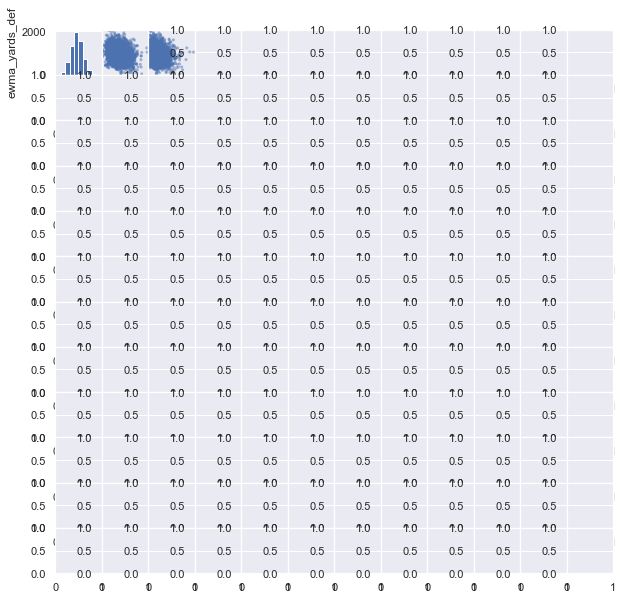

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
pd.plotting.scatter_matrix(X[X.columns[10:20]], ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
pd.plotting.scatter_matrix(X[X.columns[-6:]], ax=ax);

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k=10).fit_transform(X, y)